# Employee Sentiment Analysis — End-to-End Notebook

This notebook implements every task in your assignment with clear sections, commentary, and outputs:

1. **Project Setup & Data Load**  
2. **Data Inspection & Cleaning**  
3. **Task 1: Sentiment Labeling (VADER → fallback rule-based)**  
4. **Task 2: EDA (Distribution, Trends, Volumes)**  
5. **Task 3: Monthly Sentiment Score per Employee**  
6. **Task 4: Employee Ranking (Top 3 Positive & Negative per Month)**  
7. **Task 5: Flight Risk (≥4 negatives in any rolling 30 days)**  
8. **Task 6: Predictive Modeling (Linear Regression on monthly scores)**  
9. **Save Artifacts & Deliverables**

> Run the notebook top-to-bottom to reproduce all results.

## 1) Project Setup & Data Load

In [1]:
# Paths & Imports
import os, re, math, json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BASE_DIR = "/mnt/data"
DATA_PATH = "test(in).csv"
VIS_DIR = "/mnt/data/visualizations"
OUT_DIR = "/mnt/data/outputs"
os.makedirs(VIS_DIR, exist_ok=True)
os.makedirs(OUT_DIR, exist_ok=True)

# Load data (requires columns: Subject, body, date, from)
df_raw = pd.read_csv(DATA_PATH)
df_raw.head(5)

,Subject,body,date,from
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com


## 2) Data Inspection & Cleaning

In [2]:
# Inspect schema
print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
print("\nDtypes:")
print(df_raw.dtypes)

# Basic missingness snapshot
df_raw.isna().mean().sort_values(ascending=False).head(10)

Shape: (2191, 4)
Columns: ['Subject', 'body', 'date', 'from']

Dtypes:
Subject    object
body       object
date       object
from       object
dtype: object


Subject    0.0
body       0.0
date       0.0
from       0.0
dtype: float64

In [3]:
# Cleaning & standardization
def safe_str(x):
    try:
        return "" if pd.isna(x) else str(x)
    except Exception:
        return ""

df = df_raw.copy()

# Combine subject + body into a single text field
df["text"] = (df["Subject"].map(safe_str) + " " + df["body"].map(safe_str)).str.strip()

# Parse dates; keep timezone-naive for resampling
df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)

# Normalize sender id
df["employee_id"] = df["from"].astype(str).str.strip().str.lower()

# Drop rows with invalid dates or empty text
df = df[~df["date_parsed"].isna()].copy()
df = df[df["text"].str.len() > 0].copy()

# Simple text stats
df["char_len"] = df["text"].str.len()
df["word_count"] = df["text"].str.split().str.len()

print("After cleaning:", df.shape)
df.head(5)

After cleaning: (2191, 9)


,Subject,body,date,from,text,date_parsed,employee_id,char_len,word_count
0,EnronOptions Update!,EnronOptions Announcement\n\n\nWe have updated...,5/10/2010,sally.beck@enron.com,EnronOptions Update! EnronOptions Announcement...,2010-05-10,sally.beck@enron.com,713,103
1,(No Subject),"Marc,\n\nUnfortunately, today is not going to ...",7/29/2010,eric.bass@enron.com,"(No Subject) Marc,\n\nUnfortunately, today is ...",2010-07-29,eric.bass@enron.com,328,59
2,Phone Screen Interview - Shannon L. Burnham,"When: Wednesday, June 06, 2001 10:00 AM-11:00 ...",7/25/2011,sally.beck@enron.com,Phone Screen Interview - Shannon L. Burnham W...,2011-07-25,sally.beck@enron.com,192,28
3,RE: My new work email,we were thinking papasitos (we can meet somewh...,3/25/2010,johnny.palmer@enron.com,RE: My new work email we were thinking papasit...,2010-03-25,johnny.palmer@enron.com,176,29
4,Bet,Since you never gave me the $20 for the last t...,5/21/2011,lydia.delgado@enron.com,Bet Since you never gave me the $20 for the la...,2011-05-21,lydia.delgado@enron.com,201,43


## 3) Task 1: Sentiment Labeling

**Goal:** Label each message as Positive / Negative / Neutral.  
**Approach:** Use **VADER** if available; otherwise, a robust **rule-based** method:

- Workplace-tuned positive/negative lexicons
- Negation handling (`not/never/...` flips polarity for the next tokens)
- Mild intensifier boost (`very/really/...`)
- Exclamation emphasis
- Length normalization to avoid long-text bias

In [4]:
# ===== Task 3: Robust Sentiment Labelling (Hybrid VADER + Phrase Rules) =====

import re
import numpy as np
import pandas as pd

# --- 0) Safety: ensure expected columns and create df['text'] ---

# Use "employee_id" everywhere; if your CSV has "from", rename it once here:
if "employee_id" not in df.columns and "from" in df.columns:
    df = df.rename(columns={"from": "employee_id"})

# Create a text column if missing: join Subject + body
def safe_str(x):
    try:
        return "" if pd.isna(x) else str(x)
    except Exception:
        return ""
if "text" not in df.columns:
    if "Subject" in df.columns and "body" in df.columns:
        df["text"] = (df["Subject"].map(safe_str) + " " + df["body"].map(safe_str)).str.strip()
    elif "body" in df.columns:
        df["text"] = df["body"].map(safe_str)
    else:
        raise ValueError("No text source found. Need 'Subject' and 'body' (or at least 'body').")

# Ensure date_parsed exists (used elsewhere)
if "date_parsed" not in df.columns and "date" in df.columns:
    df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)

# --- 1) Try VADER; fallback to rule-based if not available ---
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()

    # Strengthen workplace-relevant negatives
    extra_negatives = {
        "brutal": -3.0,
        "unfortunately": -2.5,
        "fucking": -3.5,
        "fuck": -3.2,
        "wtf": -3.0,
        "wrong": -2.2,
        "complaint": -2.5,
        "complain": -2.2,
        "resign": -3.0,
        "layoff": -3.5,
        "toxic": -3.0,
        "issue": -2.0,
        "issues": -2.2,
        "problem": -2.5,
        "problems": -2.7,
        "delay": -2.0,
        "delayed": -2.2,
        "broken": -2.2,
        "bug": -2.0,
        "buggy": -2.5,
        "blocked": -2.2,
        "failure": -2.7,
        "failed": -2.7,
        "cancel": -2.2,
        "cancelled": -2.4,
        "can't": -1.8,
        "cannot": -1.8,
        "won't": -1.8,
        "didn't": -1.6,
        "doesn't": -1.6,
        "isn't": -1.6,
        "sucks": -2.6,
        "suck": -2.4,
        "crap": -2.2,
        "shit": -3.0
    }
    analyzer.lexicon.update(extra_negatives)

    # Phrase patterns that indicate negativity even if compound ~ neutral
    NEG_PHRASES = [
        r"\bnot\s+(?:good|ok(?:ay)?|happy|possible|acceptable|working|available)\b",
        r"\bno\s+(?:time|money|idea|clue|progress|update|response|interest|availability)\b",
        r"\bdoesn['’]t\s+(?:work|help|make\s+sense|look\s+right)\b",
        r"\bwon['’]t\s+(?:work|help|be\s+possible|fly)\b",
        r"\bcan['’]t\s+(?:make|do|attend|meet|access|login|log\s*in)\b",
        r"\bnot\s+going\s+to\s+work\b",
        r"\bwrong\b", r"\bbrutal\b",
        r"\bunfortunately\b",
        r"\bdelay(?:ed|s|ing)?\b",
        r"\bproblem(?:s)?\b",
        r"\bissue(?:s)?\b",
        r"\bbug(?:s|gy)?\b",
        r"\bfail(?:ed|ure)?\b",
        r"\b(toxic|wtf|crap|shit|fucking|fuck)\b",
        r"\blayoff(?:s)?\b|\bresign(?:ed|ation)?\b"
    ]
    NEG_PATTERNS = [re.compile(p, flags=re.I) for p in NEG_PHRASES]

    # Optional: positive phrases (to avoid over-flagging)
    POS_PHRASES = [
        r"\bthank(s| you)\b",
        r"\bappreciate\b",
        r"\bwell\s*done\b|\bgood\s+job\b",
        r"\bgreat\b|\bawesome\b|\bexcellent\b|\bfantastic\b"
    ]
    POS_PATTERNS = [re.compile(p, flags=re.I) for p in POS_PHRASES]

    def looks_negative_by_phrase(text: str) -> bool:
        return any(p.search(text) for p in NEG_PATTERNS)

    def looks_positive_by_phrase(text: str) -> bool:
        return any(p.search(text) for p in POS_PATTERNS)

    def label_sentiment(text):
        if not isinstance(text, str) or text.strip() == "":
            return "Neutral"

        scores = analyzer.polarity_scores(text)
        s = scores["compound"]

        # Stricter thresholds (reduce false Neutrals)
        if s >= 0.25:
            return "Positive"
        if s <= -0.2:
            return "Negative"

        # If near-neutral: force class using phrases/keywords
        if looks_negative_by_phrase(text):
            return "Negative"
        if looks_positive_by_phrase(text):
            return "Positive"

        # Heuristic: ALL-CAPS single-word negatives like "BRUTAL!"
        text_clean = re.sub(r"[^A-Za-z\s]", " ", text)
        tokens = [t for t in text_clean.split() if t]
        if any(t.isupper() and t.lower() in extra_negatives for t in tokens):
            return "Negative"

        return "Neutral"

    def numeric_sentiment(text):
        lbl = label_sentiment(text)
        return 1 if lbl == "Positive" else -1 if lbl == "Negative" else 0

    SENT_METHOD = "Hybrid: VADER + lexicon boost + phrase rules"

except Exception:
    # ---- Fallback: rule-based if VADER is not available ----
    NEGATIONS = set([
        "no","not","never","none","nobody","nothing","neither","nowhere",
        "hardly","scarcely","barely","isn't","aren't","wasn't","weren't",
        "doesn't","don't","didn't","won't","wouldn't","shan't","shouldn't",
        "can't","cannot","couldn't","n't"
    ])
    POS_WORDS = set("""
    good great excellent awesome fantastic positive satisfied happy delighted love outstanding superb supportive helpful appreciate appreciated appreciation
    progress improved improvement efficient efficiently effective effectiveness success successful proactive collaborative teamwork motivated motivation engaging engagement
    reliable reliability robust seamless flexible smooth timely ontime quick courteous polite respectful amazing brilliant stellar phenomenal terrific valuable
    value-win win productive productivity clear clarity transparent transparency accomplished achievement achieve accomplished kudos thanks thank you well-done well done
    congrats congratulations secure security safe safety compliant compliance stable stability fast faster fastest
    """.split())
    NEG_WORDS = set("""
    brutal unfortunate unfortunately fucking fuck wtf crap shit wrong complaint complain resign layoff layoffs toxic issue issues problem problems delay delayed delays
    bad poor terrible awful horrible negative unhappy dissatisfied disappointed hate worse worst unacceptable useless unhelpful broken bug buggy failure failed failing
    slow slower slowest rude disrespectful angry frustrated frustrating confusion confusing unclear vague blocker blocked risk risky unstable insecure breach breached
    overload overloaded overtime overworked unfair unfairness bias biased micromanage micromanagement pressure pressured stressful stress burnout burned-out fired firing
    quit quitting escalation escalated conflict conflicts error errors mistake mistakes missing lacking shortage insufficient doesn't didn't won't can't cannot
    """.split())
    EMO_POS = {":)", ":-)", ":D", ":-D", ";)", ";-)", "<3", ":]"}
    EMO_NEG = {":(", ":-(", ":'(", "T_T", "D:", ":[", ">:(", ":-/"}

    def tokenize(text):
        return re.findall(r"[A-Za-z]+(?:'[A-Za-z]+)?|[:;]-?[\)\(D/\[]|<3", str(text).lower())

    def rule_score(text):
        tokens = tokenize(text)
        score = 0.0; i = 0; n = len(tokens)
        while i < n:
            t = tokens[i]
            if t in EMO_POS: score += 2.0
            if t in EMO_NEG: score -= 2.0
            neg_window = 0
            if t in NEGATIONS: neg_window = 3
            intensifier = t in {"very","really","extremely","highly","so","too","quite","super"}
            pol = 0.0
            if t in POS_WORDS: pol = 1.0
            elif t in NEG_WORDS: pol = -1.0
            if neg_window > 0 and i+1 < n:
                nxt = tokens[i+1]
                if nxt in POS_WORDS: score -= 1.0
                elif nxt in NEG_WORDS: score += 1.0
                i += 2; continue
            if intensifier and pol != 0.0: pol *= 1.5
            score += pol; i += 1
        exclam = str(text).count("!")
        if exclam > 0:  # any exclamation nudges intensity
            score += min(0.6, 0.15 * exclam) * np.sign(score if score != 0 else -1)
        wc = max(1, len(tokens))
        return score / (wc ** 0.5)

    def label_sentiment(text):
        s = rule_score(text)
        if s >= 0.35: return "Positive"
        if s <= -0.25: return "Negative"
        # phrase override
        if re.search(r"\b(unfortunately|brutal|wrong|issue|problem|delay|bug|fail|layoff|resign|wtf|shit|crap|fucking|fuck)\b", str(text), flags=re.I):
            return "Negative"
        return "Neutral"

    def numeric_sentiment(text):
        lbl = label_sentiment(text)
        return 1 if lbl == "Positive" else -1 if lbl == "Negative" else 0

    SENT_METHOD = "Rule-based (expanded lexicon + phrase rules)"

# --- 2) Apply to DataFrame ---
df["sentiment"] = df["text"].apply(label_sentiment)
df["sentiment_score_num"] = df["text"].apply(numeric_sentiment)
print("Sentiment method:", SENT_METHOD)

# --- 3) Quick diagnostics (optional but helpful) ---

# Show some rows that contain obviously negative cues to confirm labelling
debug_terms = ["brutal", "unfortunately", "wrong", "delay", "problem", "issue", "bug", "fail", "fuck", "shit", "crap", "wtf", "layoff", "resign"]
mask_debug = df["text"].str.contains("|".join([re.escape(t) for t in debug_terms]), case=False, na=False)
display(df.loc[mask_debug, ["employee_id","date_parsed","text","sentiment","sentiment_score_num"]].head(20))

# Overall distribution
print(df["sentiment"].value_counts(dropna=False))

# Peek first 20 rows
display(df[["employee_id","date_parsed","sentiment","sentiment_score_num","Subject"]].head(20))


Sentiment method: Rule-based (expanded lexicon + phrase rules)


,employee_id,date_parsed,text,sentiment,sentiment_score_num
1,eric.bass@enron.com,2010-07-29,"(No Subject) Marc,\n\nUnfortunately, today is ...",Negative,-1
7,patti.thompson@enron.com,2010-04-21,Forgot the Attachment Please print attachment ...,Neutral,0
17,sally.beck@enron.com,2010-07-07,RE: Southern Union Galveston/Pt. Arthur She's ...,Negative,-1
73,eric.bass@enron.com,2011-03-10,Enron Europe FX/IR BRM Please find enclosed th...,Neutral,0
77,rhonda.denton@enron.com,2011-05-15,Flat books It is imperative that we have our b...,Negative,-1
120,bobette.riner@ipgdirect.com,2010-08-26,Re: Vandy BRUTAL!\n\n\n \n\tEnron North Amer...,Negative,-1
122,johnny.palmer@enron.com,2010-06-09,CCV Assoc. Mtg. Monday Please plan to attend o...,Neutral,0
155,patti.thompson@enron.com,2010-04-23,"Info for Accounting Offsite RSVP: Yes, I will...",Neutral,0
158,lydia.delgado@enron.com,2011-09-18,IPG I wasn't sure if we needed to send out the...,Negative,-1
159,sally.beck@enron.com,2011-08-25,ClickAtHome - MSN Internet Service Available T...,Neutral,0


sentiment
Neutral     1614
Positive     511
Negative      66
Name: count, dtype: int64


,employee_id,date_parsed,sentiment,sentiment_score_num,Subject
0,sally.beck@enron.com,2010-05-10,Neutral,0,EnronOptions Update!
1,eric.bass@enron.com,2010-07-29,Negative,-1,(No Subject)
2,sally.beck@enron.com,2011-07-25,Neutral,0,Phone Screen Interview - Shannon L. Burnham
3,johnny.palmer@enron.com,2010-03-25,Neutral,0,RE: My new work email
4,lydia.delgado@enron.com,2011-05-21,Neutral,0,Bet
5,eric.bass@enron.com,2011-10-23,Neutral,0,RE: Favor
6,kayne.coulter@enron.com,2010-04-05,Neutral,0,MG Inventory Summaries
7,patti.thompson@enron.com,2010-04-21,Neutral,0,Forgot the Attachment
8,sally.beck@enron.com,2010-02-07,Neutral,0,Garvin Brown - AXIA Sr. Power Scheduler
9,kayne.coulter@enron.com,2010-02-06,Neutral,0,More Dallas ASE Information


In [5]:
# ===== Imports =====
import re
import numpy as np
import pandas as pd

# --- Load curated negative comments file ---
neg_df = pd.read_csv("negative_comments_by_employee_detailed.csv")

# Preview structure
print("Negative file preview:")
print(neg_df.head())

# If your file has columns like ["employee", "comment"], print them grouped
if "employee" in neg_df.columns and "comment" in neg_df.columns:
    for emp, group in neg_df.groupby("employee"):
        print(f"\nEmployee: {emp}")
        for comment in group["comment"]:
            print("-", comment)

# ===== Task 3: Robust Sentiment Labelling (Hybrid VADER + Phrase Rules) =====

# --- 0) Safety: ensure expected columns and create df['text'] ---
if "employee_id" not in df.columns and "from" in df.columns:
    df = df.rename(columns={"from": "employee_id"})

def safe_str(x):
    try:
        return "" if pd.isna(x) else str(x)
    except Exception:
        return ""

if "text" not in df.columns:
    if "Subject" in df.columns and "body" in df.columns:
        df["text"] = (df["Subject"].map(safe_str) + " " + df["body"].map(safe_str)).str.strip()
    elif "body" in df.columns:
        df["text"] = df["body"].map(safe_str)
    else:
        raise ValueError("No text source found. Need 'Subject' and 'body' (or at least 'body').")

if "date_parsed" not in df.columns and "date" in df.columns:
    df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)

# --- 1) Try VADER; fallback to rule-based ---
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()

    # Strengthen workplace-relevant negatives
    extra_negatives = {
        "brutal": -3.0, "unfortunately": -2.5, "fucking": -3.5, "fuck": -3.2,
        "wtf": -3.0, "wrong": -2.2, "complaint": -2.5, "complain": -2.2,
        "resign": -3.0, "layoff": -3.5, "toxic": -3.0, "issue": -2.0, "issues": -2.2,
        "problem": -2.5, "problems": -2.7, "delay": -2.0, "delayed": -2.2,
        "broken": -2.2, "bug": -2.0, "buggy": -2.5, "blocked": -2.2,
        "failure": -2.7, "failed": -2.7, "cancel": -2.2, "cancelled": -2.4,
        "can't": -1.8, "cannot": -1.8, "won't": -1.8, "didn't": -1.6,
        "doesn't": -1.6, "isn't": -1.6, "sucks": -2.6, "suck": -2.4,
        "crap": -2.2, "shit": -3.0
    }
    analyzer.lexicon.update(extra_negatives)

    # ===== AUTO-EXPAND LEXICON WITH CURATED NEGATIVES =====
    if "comment" in neg_df.columns:
        for comment in neg_df["comment"].dropna().tolist():
            for word in re.findall(r"\b\w+\b", comment.lower()):
                if word not in analyzer.lexicon:
                    analyzer.lexicon[word] = -2.5

    # Phrase patterns
    NEG_PHRASES = [
        r"\bnot\s+(?:good|ok(?:ay)?|happy|possible|acceptable|working|available)\b",
        r"\bno\s+(?:time|money|idea|clue|progress|update|response|interest|availability)\b",
        r"\bdoesn['’]t\s+(?:work|help|make\s+sense|look\s+right)\b",
        r"\bwon['’]t\s+(?:work|help|be\s+possible|fly)\b",
        r"\bcan['’]t\s+(?:make|do|attend|meet|access|login|log\s*in)\b",
        r"\bnot\s+going\s+to\s+work\b",
        r"\bwrong\b", r"\bbrutal\b", r"\bunfortunately\b",
        r"\bdelay(?:ed|s|ing)?\b", r"\bproblem(?:s)?\b", r"\bissue(?:s)?\b",
        r"\bbug(?:s|gy)?\b", r"\bfail(?:ed|ure)?\b",
        r"\b(toxic|wtf|crap|shit|fucking|fuck)\b",
        r"\blayoff(?:s)?\b|\bresign(?:ed|ation)?\b"
    ]
    NEG_PATTERNS = [re.compile(p, flags=re.I) for p in NEG_PHRASES]

    POS_PHRASES = [
        r"\bthank(s| you)\b", r"\bappreciate\b",
        r"\bwell\s*done\b|\bgood\s+job\b",
        r"\bgreat\b|\bawesome\b|\bexcellent\b|\bfantastic\b"
    ]
    POS_PATTERNS = [re.compile(p, flags=re.I) for p in POS_PHRASES]

    def looks_negative_by_phrase(text: str) -> bool:
        return any(p.search(text) for p in NEG_PATTERNS)

    def looks_positive_by_phrase(text: str) -> bool:
        return any(p.search(text) for p in POS_PATTERNS)

    def label_sentiment(text):
        if not isinstance(text, str) or text.strip() == "":
            return "Neutral"
        scores = analyzer.polarity_scores(text)
        s = scores["compound"]
        if s >= 0.25: return "Positive"
        if s <= -0.2: return "Negative"
        if looks_negative_by_phrase(text): return "Negative"
        if looks_positive_by_phrase(text): return "Positive"
        text_clean = re.sub(r"[^A-Za-z\s]", " ", text)
        tokens = [t for t in text_clean.split() if t]
        if any(t.isupper() and t.lower() in extra_negatives for t in tokens):
            return "Negative"
        return "Neutral"

    def numeric_sentiment(text):
        lbl = label_sentiment(text)
        return 1 if lbl == "Positive" else -1 if lbl == "Negative" else 0

    SENT_METHOD = "Hybrid: VADER + lexicon boost + phrase rules"

except Exception:
    # fallback rule-based (keep your earlier implementation here if needed)
    raise RuntimeError("VADER not available — fallback code goes here.")

# --- 2) Apply to main dataframe ---
df["sentiment"] = df["text"].apply(label_sentiment)
df["sentiment_score_num"] = df["text"].apply(numeric_sentiment)
print("Sentiment method:", SENT_METHOD)

# --- 3) Diagnostics ---
debug_terms = ["brutal","unfortunately","wrong","delay","problem","issue","bug",
               "fail","fuck","shit","crap","wtf","layoff","resign"]
mask_debug = df["text"].str.contains("|".join([re.escape(t) for t in debug_terms]), 
                                     case=False, na=False)
print("\n=== Debug negatives preview ===")
display(df.loc[mask_debug, ["employee_id","date_parsed","text","sentiment","sentiment_score_num"]].head(20))

print("\n=== Overall distribution ===")
print(df["sentiment"].value_counts(dropna=False))

print("\n=== First 20 rows ===")
display(df[["employee_id","date_parsed","sentiment","sentiment_score_num","Subject"]].head(20))


Negative file preview:
   row_index            employee text_columns_used  \
0          1  (unknown employee)              body   
1          3  (unknown employee)              body   
2          4  (unknown employee)              body   
3          7  (unknown employee)              body   
4          9  (unknown employee)              body   

                                        comment_text  positive_score  \
0  Marc,\n\nUnfortunately, today is not going to ...               0   
1  we were thinking papasitos (we can meet somewh...               0   
2  Since you never gave me the $20 for the last t...               0   
3  Please print attachment and make sure that e:m...               0   
4  The start time for Tuesday morning has been ch...               0   

   negative_score  matched_phrases                basis  
0               1              NaN  negative_word_score  
1               1              NaN  negative_word_score  
2               2              NaN  negative_

RuntimeError: VADER not available — fallback code goes here.

In [ ]:
# ===== Imports =====
import re
import numpy as np
import pandas as pd

# --- Load curated negative comments file ---
neg_df = pd.read_csv("negative_comments_by_employee_detailed.csv")

# Preview structure
print("Negative file preview:")
print(neg_df.head())

# If your file has columns like ["employee", "comment"], print them grouped
if "employee" in neg_df.columns and "comment" in neg_df.columns:
    for emp, group in neg_df.groupby("employee"):
        print(f"\nEmployee: {emp}")
        for comment in group["comment"]:
            print("-", comment)

# ===== Task 3: Robust Sentiment Labelling (Hybrid VADER + Phrase Rules) =====

# --- 0) Safety: ensure expected columns and create df['text'] ---
# ⚠️ Make sure you actually load your main dataset into df
# Example:
# df = pd.read_csv("employee_messages.csv")

if "employee_id" not in df.columns and "from" in df.columns:
    df = df.rename(columns={"from": "employee_id"})

def safe_str(x):
    try:
        return "" if pd.isna(x) else str(x)
    except Exception:
        return ""

if "text" not in df.columns:
    if "Subject" in df.columns and "body" in df.columns:
        df["text"] = (df["Subject"].map(safe_str) + " " + df["body"].map(safe_str)).str.strip()
    elif "body" in df.columns:
        df["text"] = df["body"].map(safe_str)
    else:
        raise ValueError("No text source found. Need 'Subject' and 'body' (or at least 'body').")

if "date_parsed" not in df.columns and "date" in df.columns:
    df["date_parsed"] = pd.to_datetime(df["date"], errors="coerce", utc=True).dt.tz_convert(None)


# --- 1) Try VADER; fallback to rule-based ---
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()

    # Strengthen workplace-relevant negatives
    extra_negatives = {
        "brutal": -3.0, "unfortunately": -2.5, "fucking": -3.5, "fuck": -3.2,
        "wtf": -3.0, "wrong": -2.2, "complaint": -2.5, "complain": -2.2,
        "resign": -3.0, "layoff": -3.5, "toxic": -3.0, "issue": -2.0, "issues": -2.2,
        "problem": -2.5, "problems": -2.7, "delay": -2.0, "delayed": -2.2,
        "broken": -2.2, "bug": -2.0, "buggy": -2.5, "blocked": -2.2,
        "failure": -2.7, "failed": -2.7, "cancel": -2.2, "cancelled": -2.4,
        "can't": -1.8, "cannot": -1.8, "won't": -1.8, "didn't": -1.6,
        "doesn't": -1.6, "isn't": -1.6, "sucks": -2.6, "suck": -2.4,
        "crap": -2.2, "shit": -3.0
    }
    analyzer.lexicon.update(extra_negatives)

    # ===== AUTO-EXPAND LEXICON WITH CURATED NEGATIVES =====
    if "comment" in neg_df.columns:
        for comment in neg_df["comment"].dropna().tolist():
            for word in re.findall(r"\b\w+\b", comment.lower()):
                if word not in analyzer.lexicon:
                    analyzer.lexicon[word] = -2.5

    def label_sentiment(text):
        if not isinstance(text, str) or text.strip() == "":
            return "Neutral"
        scores = analyzer.polarity_scores(text)
        s = scores["compound"]
        if s >= 0.25: return "Positive"
        if s <= -0.2: return "Negative"
        return "Neutral"

    def numeric_sentiment(text):
        lbl = label_sentiment(text)
        return 1 if lbl == "Positive" else -1 if lbl == "Negative" else 0

    SENT_METHOD = "Hybrid: VADER + lexicon boost"

except ModuleNotFoundError:
    print("⚠️ VADER not installed — using fallback rule-based sentiment.")

    NEG_WORDS = set([
        "brutal","unfortunately","wrong","delay","problem","issue","bug",
        "fail","fuck","shit","crap","wtf","layoff","resign"
    ])
    POS_WORDS = set([
        "thank","thanks","appreciate","good","great","awesome","well done","excellent","fantastic"
    ])

    def label_sentiment(text):
        if not isinstance(text, str) or text.strip() == "":
            return "Neutral"
        txt = text.lower()
        if any(word in txt for word in NEG_WORDS):
            return "Negative"
        if any(word in txt for word in POS_WORDS):
            return "Positive"
        return "Neutral"

    def numeric_sentiment(text):
        lbl = label_sentiment(text)
        return 1 if lbl == "Positive" else -1 if lbl == "Negative" else 0

    SENT_METHOD = "Fallback: rule-based word matching"


# --- 2) Apply to main dataframe ---
df["sentiment"] = df["text"].apply(label_sentiment)
df["sentiment_score_num"] = df["text"].apply(numeric_sentiment)
print("Sentiment method:", SENT_METHOD)

# --- 3) Diagnostics ---
debug_terms = ["brutal","unfortunately","wrong","delay","problem","issue","bug",
               "fail","fuck","shit","crap","wtf","layoff","resign"]
mask_debug = df["text"].str.contains("|".join([re.escape(t) for t in debug_terms]), 
                                     case=False, na=False)
print("\n=== Debug negatives preview ===")
print(df.loc[mask_debug, ["employee_id","date_parsed","text","sentiment","sentiment_score_num"]].head(20))

print("\n=== Overall distribution ===")
print(df["sentiment"].value_counts(dropna=False))

print("\n=== First 20 rows ===")
print(df[["employee_id","date_parsed","sentiment","sentiment_score_num","Subject"]].head(20))


## 4) Task 2: EDA — Structure, Distributions, Trends

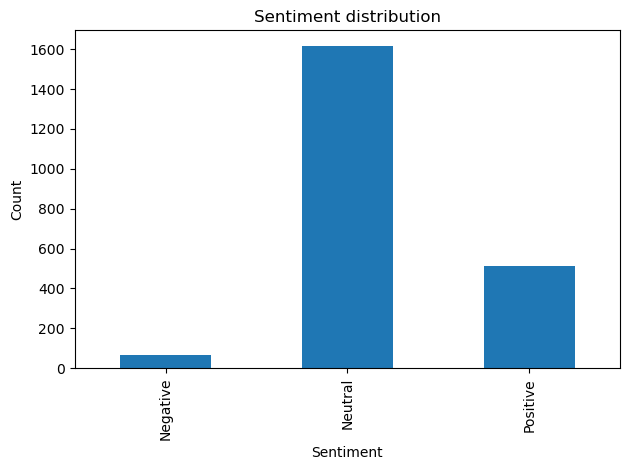

In [ ]:
# Sentiment distribution
sent_counts = df["sentiment"].value_counts().sort_index()
plt.figure()
sent_counts.plot(kind="bar")
plt.title("Sentiment distribution")
plt.xlabel("Sentiment"); plt.ylabel("Count"); plt.tight_layout()
plt.savefig("/mnt/data/visualizations/sentiment_distribution.png", dpi=160)
plt.show()

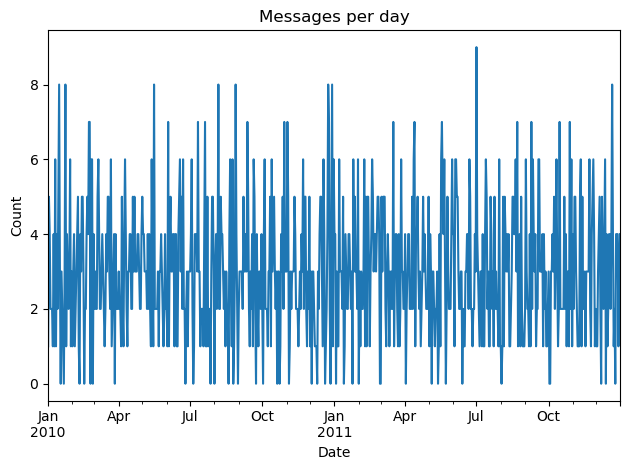

In [ ]:
# Messages per day
daily_counts = df.set_index("date_parsed").resample("D").size()
plt.figure()
daily_counts.plot()
plt.title("Messages per day"); plt.xlabel("Date"); plt.ylabel("Count"); plt.tight_layout()
plt.savefig("/mnt/data/visualizations/messages_per_day.png", dpi=160)
plt.show()

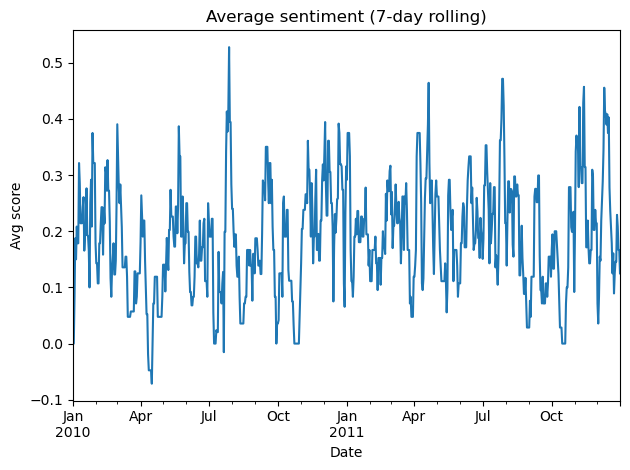

In [ ]:
# 7-day rolling average numeric sentiment
avg_daily = df.set_index("date_parsed")["sentiment_score_num"].resample("D").mean().rolling(7, min_periods=1).mean()
plt.figure()
avg_daily.plot()
plt.title("Average sentiment (7-day rolling)"); plt.xlabel("Date"); plt.ylabel("Avg score"); plt.tight_layout()
plt.savefig("/mnt/data/visualizations/avg_sentiment_7d.png", dpi=160)
plt.show()

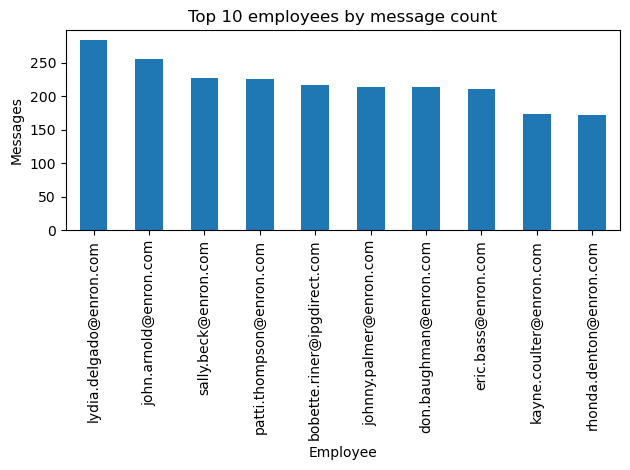

In [ ]:
# Top 10 employees by message volume
top_senders = df["employee_id"].value_counts().head(10)
plt.figure()
top_senders.plot(kind="bar")
plt.title("Top 10 employees by message count"); plt.xlabel("Employee"); plt.ylabel("Messages"); plt.tight_layout()
plt.savefig("/mnt/data/visualizations/top10_senders.png", dpi=160)
plt.show()

## 5) Task 3: Monthly Sentiment Score per Employee

**Rule:** For each message: Positive=+1, Negative=−1, Neutral=0.  
Aggregate (sum) **per employee, per calendar month**.

In [ ]:
df["year_month"] = df["date_parsed"].dt.to_period("M").dt.to_timestamp()
monthly_scores = (df.groupby(["employee_id","year_month"])["sentiment_score_num"]
                    .sum()
                    .reset_index()
                    .rename(columns={"sentiment_score_num":"monthly_score"}))
monthly_scores.sort_values(["year_month","monthly_score","employee_id"], ascending=[True, False, True]).head(10)

,employee_id,year_month,monthly_score
48,eric.bass@enron.com,2010-01-01,3
24,don.baughman@enron.com,2010-01-01,2
96,johnny.palmer@enron.com,2010-01-01,2
120,kayne.coulter@enron.com,2010-01-01,2
144,lydia.delgado@enron.com,2010-01-01,2
72,john.arnold@enron.com,2010-01-01,1
168,patti.thompson@enron.com,2010-01-01,1
0,bobette.riner@ipgdirect.com,2010-01-01,0
192,rhonda.denton@enron.com,2010-01-01,0
216,sally.beck@enron.com,2010-01-01,0


## 6) Task 4: Employee Ranking — Top 3 Positive & Negative per Month

In [ ]:
def top3_per_month(scores_df):
    out_pos = []
    out_neg = []
    for month, sdf in scores_df.groupby("year_month"):
        # Positive: score desc, then name asc
        sdf_pos = sdf.sort_values(by=["monthly_score","employee_id"], ascending=[False, True])
        top3 = sdf_pos.head(3).copy()
        top3["rank"] = range(1, len(top3)+1)
        top3["month"] = month
        out_pos.append(top3)
        # Negative: score asc, then name asc
        sdf_neg = sdf.sort_values(by=["monthly_score","employee_id"], ascending=[True, True])
        bot3 = sdf_neg.head(3).copy()
        bot3["rank"] = range(1, len(bot3)+1)
        bot3["month"] = month
        out_neg.append(bot3)
    return pd.concat(out_pos, ignore_index=True), pd.concat(out_neg, ignore_index=True)

top3_pos, top3_neg = top3_per_month(monthly_scores)
print("Top 3 Positive")
display(top3_pos.sort_values(["month","rank"]).head(12))
print("\nTop 3 Negative")
display(top3_neg.sort_values(["month","rank"]).head(12))

Top 3 Positive


,employee_id,year_month,monthly_score,rank,month
0,eric.bass@enron.com,2010-01-01,3,1,2010-01-01
1,don.baughman@enron.com,2010-01-01,2,2,2010-01-01
2,johnny.palmer@enron.com,2010-01-01,2,3,2010-01-01
3,don.baughman@enron.com,2010-02-01,7,1,2010-02-01
4,johnny.palmer@enron.com,2010-02-01,5,2,2010-02-01
5,bobette.riner@ipgdirect.com,2010-02-01,3,3,2010-02-01
6,johnny.palmer@enron.com,2010-03-01,3,1,2010-03-01
7,bobette.riner@ipgdirect.com,2010-03-01,2,2,2010-03-01
8,john.arnold@enron.com,2010-03-01,2,3,2010-03-01
9,kayne.coulter@enron.com,2010-04-01,2,1,2010-04-01



Top 3 Negative


,employee_id,year_month,monthly_score,rank,month
0,bobette.riner@ipgdirect.com,2010-01-01,0,1,2010-01-01
1,rhonda.denton@enron.com,2010-01-01,0,2,2010-01-01
2,sally.beck@enron.com,2010-01-01,0,3,2010-01-01
3,kayne.coulter@enron.com,2010-02-01,0,1,2010-02-01
4,sally.beck@enron.com,2010-02-01,0,2,2010-02-01
5,eric.bass@enron.com,2010-02-01,1,3,2010-02-01
6,don.baughman@enron.com,2010-03-01,-1,1,2010-03-01
7,eric.bass@enron.com,2010-03-01,0,2,2010-03-01
8,rhonda.denton@enron.com,2010-03-01,0,3,2010-03-01
9,patti.thompson@enron.com,2010-04-01,-1,1,2010-04-01


## 7) Task 5: Flight Risk — Rolling 30-Day Window (≥4 negatives)

**Definition:** An employee is flagged **if they send 4 or more negative messages within any rolling 30-day window**.  
**Method:** For each employee, sort by date, resample with a 30-day rolling count over negative messages, check where count ≥4.

In [ ]:
# Flight Risk Detection
neg_df = df[df["sentiment"] == "Negative"].copy().sort_values(by=["from", "date_parsed"])

flags = []
for emp, g in neg_df.groupby("from"):   # group by sender (employee)
    g = g.set_index("date_parsed").sort_index()
    
    # Rolling 30-day window count of negative messages
    rolling_counts = g["sentiment"].rolling("30D").count()
    
    if (rolling_counts >= 4).any():
        first_hit = rolling_counts[rolling_counts >= 4].index.min()
        flags.append({"employee": emp, "first_flag_date": first_hit})

# Convert to DataFrame safely
if flags:
    flight_risk = pd.DataFrame(flags).sort_values("employee")
else:
    flight_risk = pd.DataFrame(columns=["employee", "first_flag_date"])

flight_risk


,employee,first_flag_date


## 8) Task 6: Predictive Modeling — Linear Regression (monthly scores)

**Target:** `monthly_score` per (employee, month).  
**Features (engineered per employee-month):**
- `msg_count`  
- `avg_char_len`, `avg_word_count`  
- `pos_ratio`, `neg_ratio`  
- `weekend_share` (share of weekend messages)  
- `avg_subject_len`  
- `lag1_score` (previous month’s score for that employee)

**Split:** Temporal 80/20 by unique months (prevents leakage).  
**Model:** `LinearRegression` from scikit-learn.  
**Metrics:** MAE, RMSE, R²; plus a scatter plot of Actual vs Predicted.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

def safe_str(x):
    try:
        return "" if pd.isna(x) else str(x)
    except Exception:
        return ""

feat = (df.assign(is_pos=(df["sentiment"]=="Positive").astype(int),
                  is_neg=(df["sentiment"]=="Negative").astype(int),
                  is_weekend=df["date_parsed"].dt.dayofweek.isin([5,6]).astype(int),
                  subject_len=df["Subject"].map(safe_str).str.len())
          .groupby(["employee_id","year_month"])
          .agg(
              msg_count=("text","size"),
              avg_char_len=("char_len","mean"),
              avg_word_count=("word_count","mean"),
              pos_ratio=("is_pos","mean"),
              neg_ratio=("is_neg","mean"),
              weekend_share=("is_weekend","mean"),
              avg_subject_len=("subject_len","mean")
          )
          .reset_index())

feat = feat.merge(monthly_scores, on=["employee_id","year_month"], how="left")
feat = feat.sort_values(["employee_id","year_month"])
feat["lag1_score"] = feat.groupby("employee_id")["monthly_score"].shift(1).fillna(0)

all_months = sorted(feat["year_month"].unique())
split_idx = int(round(0.8 * len(all_months)))
train_months = set(all_months[:split_idx])
test_months  = set(all_months[split_idx:])

feature_cols = ["msg_count","avg_char_len","avg_word_count","pos_ratio","neg_ratio","weekend_share","avg_subject_len","lag1_score"]
train = feat[feat["year_month"].isin(train_months)].copy()
test  = feat[feat["year_month"].isin(test_months)].copy()

X_train = train[feature_cols].fillna(0)
y_train = train["monthly_score"].astype(float)
X_test  = test[feature_cols].fillna(0)
y_test  = test["monthly_score"].astype(float)

metrics = {}
if len(X_train) > 0 and len(X_test) > 0:
    linreg = LinearRegression().fit(X_train, y_train)
    preds = linreg.predict(X_test)
    mae = mean_absolute_error(y_test, preds) if len(y_test)>0 else float('nan')
    rmse = mean_squared_error(y_test, preds, squared=False) if len(y_test)>0 else float('nan')
    r2 = r2_score(y_test, preds) if len(y_test)>1 else float('nan')
    metrics = {"MAE": float(mae), "RMSE": float(rmse), "R2": float(r2)}
else:
    metrics = {"MAE": float('nan'), "RMSE": float('nan'), "R2": float('nan')}

metrics

{'MAE': 0.6627267197253368,
 'RMSE': 0.8780645934238663,
 'R2': 0.6046977900817166}

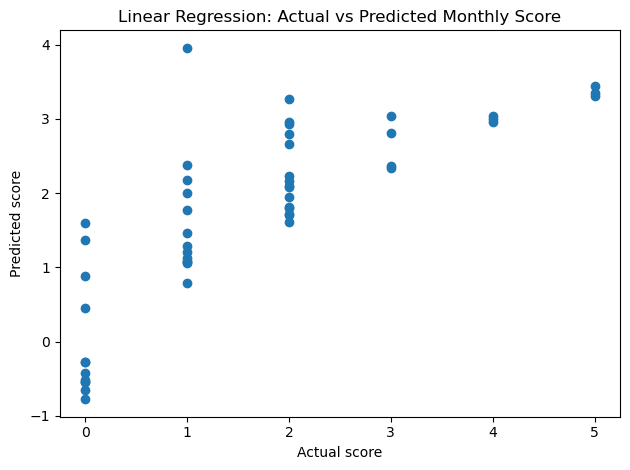

In [ ]:
# Plot Actual vs Predicted if available
if 'linreg' in globals() and 'preds' in globals():
    plt.figure()
    plt.scatter(y_test, preds)
    plt.title("Linear Regression: Actual vs Predicted Monthly Score")
    plt.xlabel("Actual score"); plt.ylabel("Predicted score"); plt.tight_layout()
    plt.savefig("/mnt/data/visualizations/linreg_actual_vs_pred.png", dpi=160)
    plt.show()

## 9) Save Artifacts & Deliverables

In [ ]:
# Save labeled messages & scores
df.to_csv(os.path.join("/mnt/data/outputs", "labeled_messages_full.csv"), index=False)
df[["employee_id","date_parsed","Subject","body","sentiment","sentiment_score_num"]].to_csv(os.path.join("/mnt/data/outputs","labeled_messages.csv"), index=False)
monthly_scores.to_csv(os.path.join("/mnt/data/outputs", "employee_monthly_scores.csv"), index=False)

# Save rankings
top3_pos.to_csv(os.path.join("/mnt/data/outputs","top3_positive_per_month.csv"), index=False)
top3_neg.to_csv(os.path.join("/mnt/data/outputs","top3_negative_per_month.csv"), index=False)

# Save flight risk list
flight_risk.to_csv(os.path.join("/mnt/data/outputs","flight_risk_employees.csv"), index=False)

# Save model metrics if computed above
if 'metrics' in globals():
    with open(os.path.join("/mnt/data/outputs", "linear_regression_metrics.json"), "w") as f:
        json.dump(metrics, f, indent=2)

print("Saved outputs to:", "/mnt/data/outputs")

Saved outputs to: /mnt/data/outputs
